# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ

# CIFAR-10 

# CNN helper functions and classes


In [25]:
import cupy as cp
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

Loading data functions

In [26]:
def load_batch(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(len(data), 3, 32, 32).astype('float32') / 255.0
        labels = np.array(labels)
    return data, labels

def load_cifar10():
    train_data = []
    train_labels = []
    for i in range(1, 6):
        data, labels = load_batch(f'cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        train_data.append(data)
        train_labels.append(labels)
    X_train = np.concatenate(train_data)
    y_train = np.concatenate(train_labels)
    X_test, y_test = load_batch('cifar-10-python/cifar-10-batches-py/test_batch')
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10()


transformation to cupy arrays for gpu

In [27]:
X_train = cp.array(X_train, dtype=cp.float32)
y_train = cp.array(y_train, dtype=cp.int32)
X_test = cp.array(X_test, dtype=cp.float32)
y_test = cp.array(y_test, dtype=cp.int32)

Functions to optimize convolution

In [28]:
def get_im2col_indices(x_shape, field_height, field_width, padding, stride):
    # Unpack the input dimensions
    N, C, H, W = x_shape  # N: batch size, C: channels, H: height, W: width

    # Calculate the dimensions of the output
    out_height = (H + 2 * padding - field_height) // stride + 1  # Output height after convolution
    out_width = (W + 2 * padding - field_width) // stride + 1   # Output width after convolution

    # Generate row indices for im2col
    i0 = cp.repeat(cp.arange(field_height), field_width)  # Repeats each row index for the width of the filter
    i0 = cp.tile(i0, C)  # Tiles the row indices for each channel

    i1 = stride * cp.repeat(cp.arange(out_height), out_width)  # Starting positions for each sliding window along height

    # Generate column indices for im2col
    j0 = cp.tile(cp.arange(field_width), field_height)  # Tiles each column index for the height of the filter
    j0 = cp.tile(j0, C)  # Tiles the column indices for each channel

    j1 = stride * cp.tile(cp.arange(out_width), out_height)  # Starting positions for each sliding window along width

    # Combine indices to get all positions for the patches
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)  # Final row indices for all patches
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)  # Final column indices for all patches

    # Generate channel indices
    k = cp.repeat(cp.arange(C), field_height * field_width).reshape(-1, 1)  # Channel indices for patches

    return (k, i, j)  # Return indices for advanced indexing


def im2col_indices(x_padded, field_height, field_width, padding, stride):
    # Get indices for im2col
    k, i, j = get_im2col_indices(x_padded.shape, field_height, field_width, padding, stride)

    # Extract patches from the padded input using advanced indexing
    cols = x_padded[:, k, i, j]  # Shape: (N, C * field_height * field_width, out_height * out_width)

    C = x_padded.shape[1]  # Number of channels

    # Reshape and transpose to get the im2col matrix
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    # Final shape: (C * field_height * field_width, N * out_height * out_width)

    return cols  # Return the im2col matrix


def col2im_indices(cols, x_shape, field_height, field_width, padding, stride):
    # Unpack the input dimensions
    N, C, H, W = x_shape  # N: batch size, C: channels, H: height, W: width

    # Initialize the padded output tensor
    x_padded = cp.zeros((N, C, H + 2 * padding, W + 2 * padding), dtype=cols.dtype)

    # Get indices for col2im
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)

    # Reshape cols to match the dimensions for addition
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)  # Shape: (N, C * field_height * field_width, out_height * out_width)

    # Add the values back into the padded output tensor using advanced indexing
    cp.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)  # Accumulates values at the specified indices

    if padding == 0:
        return x_padded  # Return without removing padding
    return x_padded[:, :, padding:-padding, padding:-padding]  # Remove padding and return the final output


In [29]:
class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        # Initialize the convolutional layer parameters
        self.stride = stride                      # Stride length for the convolution
        self.padding = padding                    # Amount of zero-padding added to the input
        self.kernel_size = kernel_size            # Size of the convolution kernel 
        
        # Initialize the weights using He initialization for ReLU activation functions
        self.W = cp.random.randn(
            out_channels,                         # Number of filters (output channels)
            in_channels,                          # Number of input channels
            kernel_size,                          # Height of the filter
            kernel_size                           # Width of the filter
        ).astype(cp.float32)
        self.W *= cp.sqrt(2. / (in_channels * kernel_size * kernel_size))
        
        # Initialize biases to zeros for each filter
        self.b = cp.zeros((out_channels, 1), dtype=cp.float32)
            
    def forward(self, x):
        # Store the input shape for use in the backward pass
        self.x_shape = x.shape
        N, C, H, W = x.shape                      # Unpack batch size and input dimensions
        
        # Apply zero-padding to the input tensor
        self.x_padded = cp.pad(
            x,
            pad_width=(
                (0, 0),                           # No padding for the batch dimension
                (0, 0),                           # No padding for the channel dimension
                (self.padding, self.padding),     # Padding for the height dimension
                (self.padding, self.padding)      # Padding for the width dimension
            ),
            mode='constant'                       # Pad with zeros
        )
        
        # Transform the input tensor into columns using the im2col_indices function
        self.cols = im2col_indices(
            self.x_padded,
            field_height=self.kernel_size,
            field_width=self.kernel_size,
            padding=0,                            # Padding is already applied, so set to zero here
            stride=self.stride
        )
        
        # Reshape the weights into a 2D matrix for matrix multiplication
        W_col = self.W.reshape(
            self.W.shape[0],                      # Number of filters
            -1                                    # Flatten the rest (in_channels * kernel_size * kernel_size)
        )
        
        # Perform the convolution as a matrix multiplication and add the biases
        out = W_col @ self.cols + self.b          # Shape: (out_channels, N * out_height * out_width)
        
        # Calculate the output dimensions after the convolution
        out_height = (H + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (W + 2 * self.padding - self.kernel_size) // self.stride + 1
        
        # Reshape the output to match the expected dimensions
        out = out.reshape(
            self.W.shape[0],                      # Number of filters (out_channels)
            out_height,                           # Output height
            out_width,                            # Output width
            N                                     # Batch size
        )
        
        # Rearrange axes to get output shape: (N, out_channels, out_height, out_width)
        out = out.transpose(3, 0, 1, 2)
        
        return out                                # Return the result of the forward pass
        
    def backward(self, dout, learning_rate, reg_lambda=0.0005):
        # Unpack the stored input dimensions
        N, C, H, W = self.x_shape
        
        # Reshape dout to match the dimensions needed for gradient computation
        dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(
            self.W.shape[0],                      # Number of filters (out_channels)
            -1                                    # Flatten the rest
        )
    
        # Compute the gradient with respect to the weights
        dW = dout_reshaped @ self.cols.T          # Matrix multiplication with the transposed input columns
        dW = dW.reshape(self.W.shape)             # Reshape to the original weight dimensions
        dW += reg_lambda * self.W  # Add regularization gradient
        # Compute the gradient with respect to the biases
        db = cp.sum(dout_reshaped, axis=1, keepdims=True)  # Sum over all examples and spatial locations
        
        # Compute the gradient with respect to the input
        W_flat = self.W.reshape(
            self.W.shape[0],                      # Number of filters
            -1                                    # Flatten the rest
        )
        dcols = W_flat.T @ dout_reshaped          # Backpropagate the gradients through the weights
        dx_padded = col2im_indices(
            dcols,
            x_shape=self.x_padded.shape,
            field_height=self.kernel_size,
            field_width=self.kernel_size,
            padding=0,                            
            stride=self.stride
        )
        
        # Remove the padding from the gradient if padding was applied
        if self.padding != 0:
            dx = dx_padded[
                :,                                 # All batches
                :,                                 # All channels
                self.padding:-self.padding,        # Remove padding from height
                self.padding:-self.padding         # Remove padding from width
            ]
        else:
            dx = dx_padded                        # No padding to remove
        
        # Update the weights and biases using the computed gradients
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        
        return dx                                 # Return the gradient with respect to the input


In [30]:
class ReLU:
    def forward(self, x):
        self.x = x
        return cp.maximum(0, x)
    
    def backward(self, dout):
        dx = dout * (self.x > 0)
        return dx


In [31]:
class MaxPool:
    def __init__(self, size=2, stride=2):
        self.size = size
        self.stride = stride

    def forward(self, x):
        # Save the input for use in the backward pass
        self.x = x
        
        # Get the dimensions of the input: N = batch size, C = number of channels, H = height, W = width
        N, C, H, W = x.shape
        
        # Calculate the height and width of the output after pooling
        self.out_height = (H - self.size) // self.stride + 1
        self.out_width = (W - self.size) // self.stride + 1

        # Reshape the input to prepare for pooling:
        # Break down the height and width 
        x_reshaped = x.reshape(N, C, self.out_height, self.stride, self.out_width, self.stride)
        
        # Reorder the dimensions to prepare for pooling and reshape to a 2D view for max operation
        self.x_reshaped = x_reshaped.transpose(0, 1, 2, 4, 3, 5).reshape(N, C, self.out_height, self.out_width, self.size * self.size)

        # Perform max pooling: take the maximum value over the pooling window
        self.out = cp.max(self.x_reshaped, axis=-1)
        
        # Create a mask to keep track of which values were selected as the max for backpropagation
        self.mask = (self.x_reshaped == self.out[..., cp.newaxis])

        return self.out

    def backward(self, dout):
        # Get the dimensions of the output gradient
        N, C, out_height, out_width = dout.shape
        
        # Use the mask to distribute the gradient to the positions that contributed to the max value
        dx_reshaped = self.mask * dout[..., cp.newaxis]
        
        # Reshape the gradient back to the original input shape
        dx_reshaped = dx_reshaped.reshape(N, C, out_height, out_width, self.size, self.size)
        
        # Reorder the dimensions back to the original input shape
        dx = dx_reshaped.transpose(0, 1, 2, 4, 3, 5).reshape(self.x.shape)
        
        return dx


In [32]:
class FCLayer:
    def __init__(self, in_size, out_size):
        # Initialize weights with He initialization 
        self.W = cp.random.randn(in_size, out_size) * cp.sqrt(2. / in_size)
        
        self.b = cp.zeros(out_size)
    
    def forward(self, x):
        # Save the input for use in the backward pass
        self.x = x
        
        # Compute the output of the fully connected layer
        out = cp.dot(x, self.W) + self.b
        
        return out

    def backward(self, dout, learning_rate, reg_lambda=0.0005):
        # Compute the gradient with respect to the input
        # dout: gradient of the loss with respect to the output of this layer
        dx = cp.dot(dout, self.W.T)
        
        # Compute the gradient with respect to the weights
        dW = cp.dot(self.x.T, dout) + reg_lambda * self.W
        
        # Compute the gradient with respect to the biases
        db = cp.sum(dout, axis=0)

        # Update the weights and biases using the computed gradients
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx


In [33]:
def softmax(x):
    exp_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true, model, reg_lambda):
    m = y_pred.shape[0]
    log_likelihood = -cp.log(y_pred[cp.arange(m), y_true] + 1e-15)
    data_loss = cp.sum(log_likelihood) / m

    # Regularization term
    reg_loss = 0
    # Collect all weights from the model
    for layer in [model.conv1, model.conv2, model.conv3, model.fc1, model.fc2]:
        if hasattr(layer, 'W'):
            reg_loss += cp.sum(layer.W ** 2)
    reg_loss *= (0.5 * reg_lambda)

    total_loss = data_loss + reg_loss
    return total_loss



def softmax_backward(dout, y_pred, y_true):
    m = y_pred.shape[0]
    dx = y_pred.copy()
    dx[cp.arange(m), y_true] -= 1
    dx /= m
    return dx


In [34]:
def random_horizontal_flip(x, p=0.5):
    if cp.random.rand() < p:
        x = x[:, :, :, ::-1]
    return x


In [35]:
def cutout(images, mask_size, p=0.5):

    N, C, H, W = images.shape
    for i in range(N):
        if cp.random.rand() > p:
            continue 

        # Choose random center position for the mask
        y_center = cp.random.randint(H)
        x_center = cp.random.randint(W)

        # Calculate mask boundaries
        y1 = cp.clip(y_center - mask_size // 2, 0, H)
        y2 = cp.clip(y_center + mask_size // 2, 0, H)
        x1 = cp.clip(x_center - mask_size // 2, 0, W)
        x2 = cp.clip(x_center + mask_size // 2, 0, W)

        # Apply the mask
        images[i, :, y1:y2, x1:x2] = 0  

    return images


In [36]:
class BatchNorm:
    def __init__(self, num_features, momentum=0.9, epsilon=1e-5):
        # Parameters for batch normalization
        self.gamma = cp.ones((1, num_features, 1, 1), dtype=cp.float32)  # Scale parameter
        self.beta = cp.zeros((1, num_features, 1, 1), dtype=cp.float32)  # Shift parameter
        self.momentum = momentum
        self.epsilon = epsilon

        # Moving averages of mean and variance for inference
        self.running_mean = cp.zeros((1, num_features, 1, 1), dtype=cp.float32)
        self.running_var = cp.ones((1, num_features, 1, 1), dtype=cp.float32)

    def forward(self, x, training=True):
        # Perform batch normalization
        if training:
            # Calculate mean and variance for the current batch
            batch_mean = cp.mean(x, axis=(0, 2, 3), keepdims=True)
            batch_var = cp.var(x, axis=(0, 2, 3), keepdims=True)

            # Normalize the input
            self.x_centered = x - batch_mean
            self.std_inv = 1.0 / cp.sqrt(batch_var + self.epsilon)
            x_norm = self.x_centered * self.std_inv

            # Scale and shift
            out = self.gamma * x_norm + self.beta

            # Update running averages
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            # Use running averages if not training
            x_norm = (x - self.running_mean) / cp.sqrt(self.running_var + self.epsilon)
            out = self.gamma * x_norm + self.beta

        # Save values for backward pass
        self.x_norm = x_norm
        return out

    def backward(self, dout, learning_rate):
        # Backpropagate through batch normalization
        N, C, H, W = dout.shape

        # Gradients with respect to scale and shift parameters
        dgamma = cp.sum(dout * self.x_norm, axis=(0, 2, 3), keepdims=True)
        dbeta = cp.sum(dout, axis=(0, 2, 3), keepdims=True)

        # Gradient with respect to the normalized input
        dx_norm = dout * self.gamma

        # Backpropagate through the normalization
        dvar = cp.sum(dx_norm * self.x_centered * -0.5 * self.std_inv**3, axis=(0, 2, 3), keepdims=True)
        dmean = cp.sum(dx_norm * -self.std_inv, axis=(0, 2, 3), keepdims=True) + dvar * cp.sum(-2 * self.x_centered, axis=(0, 2, 3), keepdims=True) / (N * H * W)

        # Gradient with respect to the input
        dx = dx_norm * self.std_inv + dvar * 2 * self.x_centered / (N * H * W) + dmean / (N * H * W)

        # Update scale and shift parameters
        self.gamma -= learning_rate * dgamma
        self.beta -= learning_rate * dbeta

        return dx


In [37]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, is_training=True):
        if is_training:
            # Create a mask with the given dropout rate
            self.mask = (cp.random.rand(*x.shape) > self.dropout_rate).astype(cp.float32)
            x = x * self.mask  # Apply the mask
        return x

    def backward(self, dout):
        # Backpropagate through the dropout mask
        if self.mask is not None:
            dout = dout * self.mask
        return dout


In [38]:
class OneCycleLR:
    def __init__(self, max_lr, total_steps, pct_start=0.5, anneal_strategy='linear', div_factor=100):
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.anneal_strategy = anneal_strategy
        self.div_factor = div_factor
        
        # Calculate learning rates for the warm-up and decay phases
        self.initial_lr = max_lr / div_factor
        self.max_lr = max_lr
        self.final_lr = self.initial_lr / div_factor

        self.step_num = 0

    def get_lr(self):
        """Calculate learning rate based on the current step and One Cycle LR policy."""
        if self.step_num <= self.total_steps * self.pct_start:
            # Warm-up phase: linearly increase from initial_lr to max_lr
            pct = self.step_num / (self.total_steps * self.pct_start)
            lr = self.initial_lr + pct * (self.max_lr - self.initial_lr)
        else:
            # Decay phase: decrease from max_lr to final_lr
            pct = (self.step_num - self.total_steps * self.pct_start) / (self.total_steps * (1 - self.pct_start))
            if self.anneal_strategy == 'cos':
                lr = self.final_lr + (self.max_lr - self.final_lr) * (0.5 * (1 + cp.cos(cp.pi * pct)))
            elif self.anneal_strategy == 'linear':
                lr = self.max_lr - pct * (self.max_lr - self.final_lr)
            
        
        return lr

    def step(self):
        self.step_num += 1

    def reset(self):
        self.step_num = 0


# Model Construction

In [39]:

# Model layers

# First Convolutional Block
class CNNModel:
    def __init__(self):
        # Initialize layers
        self.conv1 = ConvLayer(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = BatchNorm(32)
        self.relu1 = ReLU()
        self.pool1 = MaxPool(size=2, stride=2)

        self.conv2 = ConvLayer(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = BatchNorm(64)
        self.relu2 = ReLU()
        self.pool2 = MaxPool(size=2, stride=2)

        self.conv3 = ConvLayer(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = BatchNorm(128)
        self.relu3 = ReLU()
        self.pool3 = MaxPool(size=2, stride=2)

        self.flatten_size = 128 * 4 * 4

        self.fc1 = FCLayer(in_size=self.flatten_size, out_size=256)
        self.relu_fc = ReLU()
        self.dropout1 = Dropout(dropout_rate=0.5)
        self.fc2 = FCLayer(in_size=256, out_size=10)

    def forward_pass(self, X_batch, is_training=True):
        # Forward pass through the first convolutional block
        out = self.conv1.forward(X_batch)
        out = self.bn1.forward(out, training=is_training)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)

        # Second convolutional block
        out = self.conv2.forward(out)
        out = self.bn2.forward(out, training=is_training)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)

        # Third convolutional block
        out = self.conv3.forward(out)
        out = self.bn3.forward(out, training=is_training)
        out = self.relu3.forward(out)
        out = self.pool3.forward(out)

        # Flatten and pass through fully connected layers
        out = out.reshape(out.shape[0], -1)
        out = self.fc1.forward(out)
        out = self.relu_fc.forward(out)
        out = self.dropout1.forward(out, is_training=is_training)
        out = self.fc2.forward(out)

        return out

    def backward_pass(self, dout, learning_rate, reg_lambda=0.0005,weight_decay=0.0001):
        # Backward pass through the fully connected layers
        dout = self.fc2.backward(dout, learning_rate, reg_lambda)
        dout = self.dropout1.backward(dout)
        dout = self.relu_fc.backward(dout)
        dout = self.fc1.backward(dout, learning_rate, reg_lambda)
        
        # Reshape dout to match the output shape of the last pooling layer
        dout = dout.reshape(dout.shape[0], 128, 4, 4)

        # Backward pass through the third convolutional block
        dout = self.pool3.backward(dout)
        dout = self.relu3.backward(dout)
        dout = self.bn3.backward(dout, learning_rate)
        
        dout = self.conv3.backward(dout, learning_rate, reg_lambda)

        # Backward pass through the second convolutional block
        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.bn2.backward(dout, learning_rate)
        
        dout = self.conv2.backward(dout, learning_rate, reg_lambda)

        # Backward pass through the first convolutional block
        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dout = self.bn1.backward(dout, learning_rate)
        
        dout = self.conv1.backward(dout, learning_rate, reg_lambda)




Finding optimal parameters

In [40]:

cp.random.seed(42)
np.random.seed(42)

model = CNNModel()
lrs = []
losses = []
lr_start = 1e-4
lr_end = 5
num_iters = 100  
batch_size = 100
lr_mult = (lr_end / lr_start) ** (1 / num_iters)
# Subset of training data for the LR finder
subset_size = batch_size * num_iters
X_subset = X_train[:subset_size]
y_subset = y_train[:subset_size]

# Initialize learning rate and loss smoothing parameters
learning_rate = lr_start
running_loss = 0.0
avg_beta = 0.98  # For exponential moving average of loss

# Prepare progress bar
t = tqdm(range(num_iters), desc='Finding LR', unit='batch')
for i in t:
    # Get the current batch
    start = i * batch_size
    end = start + batch_size
    X_batch = X_subset[start:end]
    y_batch = y_subset[start:end]

    # Apply data augmentation if desired
    X_batch = random_horizontal_flip(X_batch)
    X_batch = cutout(X_batch, mask_size=8, p=0.5)

    # Forward pass
    out = model.forward_pass(X_batch, is_training=True)
    y_pred = softmax(out)
    loss = cross_entropy_loss(y_pred, y_batch, model, reg_lambda=0)

    # Record learning rate and loss
    lrs.append(learning_rate)
    running_loss = avg_beta * running_loss + (1 - avg_beta) * loss.item()
    smoothed_loss = running_loss / (1 - avg_beta ** (i + 1))
    losses.append(smoothed_loss)

    # Update progress bar
    t.set_postfix(loss=smoothed_loss, lr=learning_rate)

    # Backward pass
    dout = softmax_backward(None, y_pred, y_batch)
    model.backward_pass(dout, learning_rate, reg_lambda=0)  # No regularization during LR finder

    # Update learning rate exponentially
    learning_rate *= lr_mult

    # Check for divergence
    if smoothed_loss > 4 * losses[0] or np.isnan(smoothed_loss):
        print("Loss diverged; stopping LR finder.")
        break


Finding LR: 100%|██████████| 100/100 [00:13<00:00,  7.29batch/s, loss=2.53, lr=4.49]   


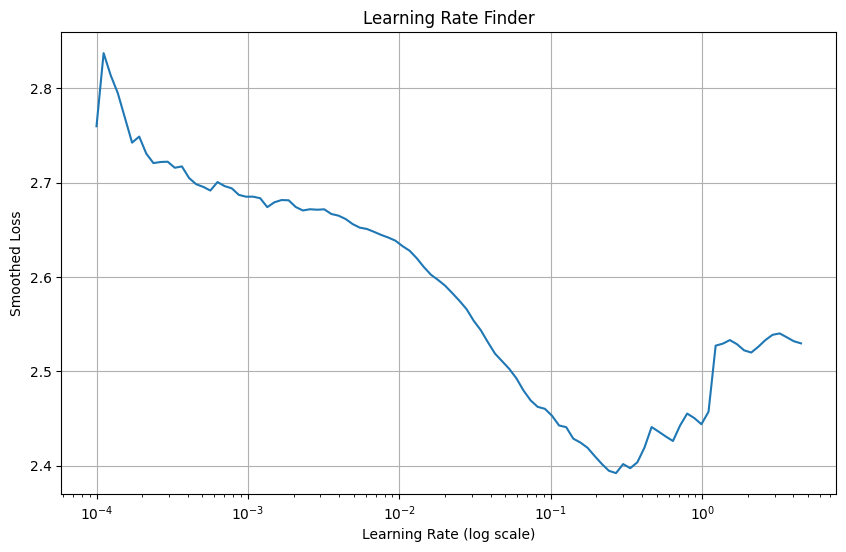

In [41]:
# Convert lists to numpy arrays for plotting
lrs_np = np.array(lrs)
losses_np = np.array(losses)

plt.figure(figsize=(10, 6))
plt.plot(lrs_np, losses_np)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Smoothed Loss')
plt.title('Learning Rate Finder')
plt.grid(True)
plt.show()


In [42]:
# Find index of minimum loss
min_loss_idx = np.argmin(losses_np)
min_loss_lr = lrs_np[min_loss_idx]

print(f"Minimum loss at LR = {min_loss_lr:.2e}")


Minimum loss at LR = 2.69e-01


# Training the model

In [43]:
# Hyperparameters

num_epochs = 70

iterations_per_epoch= X_train.shape[0] // batch_size

# Training Loop
num_batches = X_train.shape[0] // batch_size
loss_history = []
test_loss_history = []
lr_history = []
lr_sum = 0
scheduler = OneCycleLR(max_lr=0.27, total_steps=num_epochs*iterations_per_epoch, pct_start=0.5, anneal_strategy='cos', div_factor=4)

best_val_loss = float('inf')

reg_lambda = 0.0005   
model = CNNModel() # initialize the model
for epoch in range(num_epochs):
    permutation = cp.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]
    epoch_loss = 0
    lr_sum = 0
    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i in range(num_batches):
            X_batch = X_train_shuffled[i*batch_size:(i+1)*batch_size]
            y_batch = y_train_shuffled[i*batch_size:(i+1)*batch_size]

            #Data
            X_batch = random_horizontal_flip(X_batch)
            X_batch = cutout(X_batch, mask_size=8, p=0.5)
            
            # Forward pass
            out = model.forward_pass(X_batch, is_training=True)
            y_pred = softmax(out)
            loss = cross_entropy_loss(y_pred, y_batch, model, reg_lambda)
            epoch_loss += loss

            # Backward pass
            dout = softmax_backward(None, y_pred, y_batch)
            current_lr = scheduler.get_lr()  # Get the current learning rate
            model.backward_pass(dout, current_lr, reg_lambda)  # Use the current learning rate for weight updates

            
            scheduler.step()
            lr_sum+=current_lr
            # Update the progress bar
            pbar.set_postfix({'Loss': loss.item(), 'LR': current_lr})
            pbar.update(1)

    
    
    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    avg_lr = lr_sum / num_batches
    lr_history.append(avg_lr)


    
    test_loss = 0
    num_test_batches = X_test.shape[0] // batch_size
    for i in range(num_test_batches):
        X_test_batch = X_test[i*batch_size:(i+1)*batch_size]
        y_test_batch = y_test[i*batch_size:(i+1)*batch_size]
        
        # Forward pass (no gradient calculation needed)
        out = model.forward_pass(X_test_batch, is_training=False)
        y_test_pred = softmax(out)
        test_loss += cross_entropy_loss(y_test_pred, y_test_batch, model, reg_lambda)

    avg_test_loss = test_loss / num_test_batches
    test_loss_history.append(avg_test_loss)
    val_loss = avg_test_loss *100
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    lr = scheduler.get_lr()
    
    

Epoch 1/70: 100%|██████████| 500/500 [01:09<00:00,  7.19batch/s, Loss=1.62, LR=0.0733]


Epoch 1/70, Average Loss: 1.9021


Epoch 2/70: 100%|██████████| 500/500 [01:07<00:00,  7.43batch/s, Loss=1.45, LR=0.0791]


Epoch 2/70, Average Loss: 1.5819


Epoch 3/70: 100%|██████████| 500/500 [01:04<00:00,  7.80batch/s, Loss=1.33, LR=0.0848]


Epoch 3/70, Average Loss: 1.4199


Epoch 4/70: 100%|██████████| 500/500 [01:05<00:00,  7.58batch/s, Loss=1.39, LR=0.0906] 


Epoch 4/70, Average Loss: 1.3241


Epoch 5/70: 100%|██████████| 500/500 [01:08<00:00,  7.31batch/s, Loss=1.15, LR=0.0964] 


Epoch 5/70, Average Loss: 1.2583


Epoch 6/70: 100%|██████████| 500/500 [01:05<00:00,  7.61batch/s, Loss=1.37, LR=0.102]  


Epoch 6/70, Average Loss: 1.1900


Epoch 7/70: 100%|██████████| 500/500 [01:04<00:00,  7.76batch/s, Loss=1.23, LR=0.108] 


Epoch 7/70, Average Loss: 1.1359


Epoch 8/70: 100%|██████████| 500/500 [01:04<00:00,  7.77batch/s, Loss=1.05, LR=0.114] 


Epoch 8/70, Average Loss: 1.0975


Epoch 9/70: 100%|██████████| 500/500 [01:04<00:00,  7.77batch/s, Loss=0.945, LR=0.12] 


Epoch 9/70, Average Loss: 1.0590


Epoch 10/70: 100%|██████████| 500/500 [01:05<00:00,  7.61batch/s, Loss=1.1, LR=0.125]  


Epoch 10/70, Average Loss: 1.0173


Epoch 11/70: 100%|██████████| 500/500 [01:03<00:00,  7.85batch/s, Loss=0.963, LR=0.131]


Epoch 11/70, Average Loss: 0.9900


Epoch 12/70: 100%|██████████| 500/500 [01:04<00:00,  7.77batch/s, Loss=1.03, LR=0.137] 


Epoch 12/70, Average Loss: 0.9595


Epoch 13/70: 100%|██████████| 500/500 [01:02<00:00,  8.04batch/s, Loss=1.09, LR=0.143] 


Epoch 13/70, Average Loss: 0.9316


Epoch 14/70: 100%|██████████| 500/500 [01:01<00:00,  8.09batch/s, Loss=0.788, LR=0.148]


Epoch 14/70, Average Loss: 0.9168


Epoch 15/70: 100%|██████████| 500/500 [01:02<00:00,  7.94batch/s, Loss=0.827, LR=0.154]


Epoch 15/70, Average Loss: 0.8846


Epoch 16/70: 100%|██████████| 500/500 [01:01<00:00,  8.12batch/s, Loss=0.936, LR=0.16] 


Epoch 16/70, Average Loss: 0.8663


Epoch 17/70: 100%|██████████| 500/500 [01:03<00:00,  7.86batch/s, Loss=0.91, LR=0.166] 


Epoch 17/70, Average Loss: 0.8453


Epoch 18/70: 100%|██████████| 500/500 [01:02<00:00,  7.94batch/s, Loss=0.83, LR=0.172] 


Epoch 18/70, Average Loss: 0.8264


Epoch 19/70: 100%|██████████| 500/500 [01:02<00:00,  8.02batch/s, Loss=0.903, LR=0.177]


Epoch 19/70, Average Loss: 0.8128


Epoch 20/70: 100%|██████████| 500/500 [01:03<00:00,  7.85batch/s, Loss=0.98, LR=0.183] 


Epoch 20/70, Average Loss: 0.7971


Epoch 21/70: 100%|██████████| 500/500 [01:02<00:00,  7.95batch/s, Loss=0.717, LR=0.189]


Epoch 21/70, Average Loss: 0.7914


Epoch 22/70: 100%|██████████| 500/500 [01:04<00:00,  7.75batch/s, Loss=0.849, LR=0.195]


Epoch 22/70, Average Loss: 0.7749


Epoch 23/70: 100%|██████████| 500/500 [01:04<00:00,  7.72batch/s, Loss=0.656, LR=0.201]


Epoch 23/70, Average Loss: 0.7676


Epoch 24/70: 100%|██████████| 500/500 [01:07<00:00,  7.39batch/s, Loss=0.758, LR=0.206]


Epoch 24/70, Average Loss: 0.7641


Epoch 25/70: 100%|██████████| 500/500 [01:08<00:00,  7.27batch/s, Loss=0.749, LR=0.212]


Epoch 25/70, Average Loss: 0.7514


Epoch 26/70: 100%|██████████| 500/500 [01:05<00:00,  7.63batch/s, Loss=0.858, LR=0.218]


Epoch 26/70, Average Loss: 0.7431


Epoch 27/70: 100%|██████████| 500/500 [01:05<00:00,  7.64batch/s, Loss=0.6, LR=0.224]  


Epoch 27/70, Average Loss: 0.7417


Epoch 28/70: 100%|██████████| 500/500 [01:06<00:00,  7.48batch/s, Loss=0.732, LR=0.229]


Epoch 28/70, Average Loss: 0.7441


Epoch 29/70: 100%|██████████| 500/500 [01:04<00:00,  7.75batch/s, Loss=0.83, LR=0.235] 


Epoch 29/70, Average Loss: 0.7318


Epoch 30/70: 100%|██████████| 500/500 [01:04<00:00,  7.74batch/s, Loss=0.812, LR=0.241]


Epoch 30/70, Average Loss: 0.7334


Epoch 31/70: 100%|██████████| 500/500 [01:04<00:00,  7.79batch/s, Loss=0.849, LR=0.247]


Epoch 31/70, Average Loss: 0.7317


Epoch 32/70: 100%|██████████| 500/500 [01:05<00:00,  7.66batch/s, Loss=0.544, LR=0.253]


Epoch 32/70, Average Loss: 0.7351


Epoch 33/70: 100%|██████████| 500/500 [01:04<00:00,  7.70batch/s, Loss=0.726, LR=0.258]


Epoch 33/70, Average Loss: 0.7323


Epoch 34/70: 100%|██████████| 500/500 [01:05<00:00,  7.64batch/s, Loss=0.863, LR=0.264]


Epoch 34/70, Average Loss: 0.7319


Epoch 35/70: 100%|██████████| 500/500 [01:05<00:00,  7.62batch/s, Loss=0.939, LR=0.27] 


Epoch 35/70, Average Loss: 0.7336


Epoch 36/70: 100%|██████████| 500/500 [01:04<00:00,  7.72batch/s, Loss=0.797, LR=0.2694925311977443] 


Epoch 36/70, Average Loss: 0.7294


Epoch 37/70: 100%|██████████| 500/500 [01:06<00:00,  7.54batch/s, Loss=0.792, LR=0.267970143442825]  


Epoch 37/70, Average Loss: 0.7310


Epoch 38/70: 100%|██████████| 500/500 [01:06<00:00,  7.57batch/s, Loss=0.905, LR=0.2654450920669126] 


Epoch 38/70, Average Loss: 0.7200


Epoch 39/70: 100%|██████████| 500/500 [01:01<00:00,  8.12batch/s, Loss=0.961, LR=0.26193770729897975]


Epoch 39/70, Average Loss: 0.7114


Epoch 40/70: 100%|██████████| 500/500 [01:02<00:00,  8.00batch/s, Loss=0.594, LR=0.2574762285388691] 


Epoch 40/70, Average Loss: 0.7108


Epoch 41/70: 100%|██████████| 500/500 [01:02<00:00,  7.95batch/s, Loss=0.619, LR=0.25209657699024995]


Epoch 41/70, Average Loss: 0.6991


Epoch 42/70: 100%|██████████| 500/500 [01:02<00:00,  7.99batch/s, Loss=0.706, LR=0.24584206644420797]


Epoch 42/70, Average Loss: 0.6888


Epoch 43/70: 100%|██████████| 500/500 [01:02<00:00,  8.03batch/s, Loss=0.631, LR=0.2387630545420672] 


Epoch 43/70, Average Loss: 0.6785


Epoch 44/70: 100%|██████████| 500/500 [01:02<00:00,  7.98batch/s, Loss=0.703, LR=0.2309165373252721] 


Epoch 44/70, Average Loss: 0.6744


Epoch 45/70: 100%|██████████| 500/500 [01:03<00:00,  7.82batch/s, Loss=0.615, LR=0.2223656903367749] 


Epoch 45/70, Average Loss: 0.6600


Epoch 46/70: 100%|██████████| 500/500 [01:02<00:00,  7.97batch/s, Loss=0.672, LR=0.2131793599687103] 


Epoch 46/70, Average Loss: 0.6446


Epoch 47/70: 100%|██████████| 500/500 [01:03<00:00,  7.91batch/s, Loss=0.509, LR=0.20343150915172725]


Epoch 47/70, Average Loss: 0.6376


Epoch 48/70: 100%|██████████| 500/500 [01:02<00:00,  7.96batch/s, Loss=0.576, LR=0.1932006218489606] 


Epoch 48/70, Average Loss: 0.6235


Epoch 49/70: 100%|██████████| 500/500 [01:03<00:00,  7.88batch/s, Loss=0.613, LR=0.18256907114930798]


Epoch 49/70, Average Loss: 0.6130


Epoch 50/70: 100%|██████████| 500/500 [01:04<00:00,  7.79batch/s, Loss=0.489, LR=0.1716224560477523] 


Epoch 50/70, Average Loss: 0.5936


Epoch 51/70: 100%|██████████| 500/500 [01:04<00:00,  7.75batch/s, Loss=0.563, LR=0.16044891225258595]


Epoch 51/70, Average Loss: 0.5804


Epoch 52/70: 100%|██████████| 500/500 [01:03<00:00,  7.90batch/s, Loss=0.689, LR=0.14913840256851021]


Epoch 52/70, Average Loss: 0.5644


Epoch 53/70: 100%|██████████| 500/500 [01:06<00:00,  7.50batch/s, Loss=0.608, LR=0.13778199256902918]


Epoch 53/70, Average Loss: 0.5497


Epoch 54/70: 100%|██████████| 500/500 [01:08<00:00,  7.34batch/s, Loss=0.606, LR=0.1264711173899979] 


Epoch 54/70, Average Loss: 0.5305


Epoch 55/70: 100%|██████████| 500/500 [01:11<00:00,  7.00batch/s, Loss=0.512, LR=0.11529684554767086]


Epoch 55/70, Average Loss: 0.5152


Epoch 56/70: 100%|██████████| 500/500 [01:14<00:00,  6.76batch/s, Loss=0.494, LR=0.10434914570855713]


Epoch 56/70, Average Loss: 0.5032


Epoch 57/70: 100%|██████████| 500/500 [01:12<00:00,  6.91batch/s, Loss=0.362, LR=0.09371616231461799]


Epoch 57/70, Average Loss: 0.4778


Epoch 58/70: 100%|██████████| 500/500 [01:06<00:00,  7.55batch/s, Loss=0.419, LR=0.0834835058960484] 


Epoch 58/70, Average Loss: 0.4627


Epoch 59/70: 100%|██████████| 500/500 [01:04<00:00,  7.77batch/s, Loss=0.465, LR=0.0737335637856262] 


Epoch 59/70, Average Loss: 0.4454


Epoch 60/70: 100%|██████████| 500/500 [01:00<00:00,  8.24batch/s, Loss=0.419, LR=0.06454483678435136]


Epoch 60/70, Average Loss: 0.4313


Epoch 61/70: 100%|██████████| 500/500 [01:00<00:00,  8.26batch/s, Loss=0.388, LR=0.05599130711915415] 


Epoch 61/70, Average Loss: 0.4149


Epoch 62/70: 100%|██████████| 500/500 [01:00<00:00,  8.21batch/s, Loss=0.408, LR=0.048141842781504754]


Epoch 62/70, Average Loss: 0.4039


Epoch 63/70: 100%|██████████| 500/500 [01:00<00:00,  8.25batch/s, Loss=0.393, LR=0.041059643042839655]


Epoch 63/70, Average Loss: 0.3901


Epoch 64/70: 100%|██████████| 500/500 [01:00<00:00,  8.26batch/s, Loss=0.426, LR=0.034801729611188506]


Epoch 64/70, Average Loss: 0.3821


Epoch 65/70: 100%|██████████| 500/500 [01:00<00:00,  8.26batch/s, Loss=0.34, LR=0.029418487525909552] 


Epoch 65/70, Average Loss: 0.3678


Epoch 66/70: 100%|██████████| 500/500 [01:00<00:00,  8.27batch/s, Loss=0.402, LR=0.024953259486978324]


Epoch 66/70, Average Loss: 0.3588


Epoch 67/70: 100%|██████████| 500/500 [01:00<00:00,  8.23batch/s, Loss=0.324, LR=0.021441996885052723]


Epoch 67/70, Average Loss: 0.3496


Epoch 68/70: 100%|██████████| 500/500 [01:00<00:00,  8.27batch/s, Loss=0.3, LR=0.018912970342014467]  


Epoch 68/70, Average Loss: 0.3460


Epoch 69/70: 100%|██████████| 500/500 [01:00<00:00,  8.26batch/s, Loss=0.381, LR=0.01738654209254459] 


Epoch 69/70, Average Loss: 0.3419


Epoch 70/70: 100%|██████████| 500/500 [01:00<00:00,  8.26batch/s, Loss=0.371, LR=0.016875002039382532]


Epoch 70/70, Average Loss: 0.3413


# Evaluation and Results

In [44]:
def evaluate(X, y, batch_size=32):
    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size 
    correct = 0 
    total = 0

    with tqdm(total=num_batches, desc='Evaluating', unit='batch') as pbar:
        for i in range(num_batches):
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]
            
            # Forward pass
            out = model.forward_pass(X_batch, is_training=False)  
            y_pred = softmax(out)
            predictions = cp.argmax(y_pred, axis=1)
            
            # Compute the number of correct predictions
            correct += cp.sum(predictions == y_batch).item()
            total += y_batch.shape[0]
            pbar.update(1)

    accuracy = correct / total
    return accuracy


In [45]:
test_accuracy = evaluate(X_test, y_test, batch_size=100)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 44.98batch/s]

Test Accuracy: 85.39%


In [46]:
train_accuracy = evaluate(X_train, y_train, batch_size=100)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Evaluating: 100%|██████████| 500/500 [00:11<00:00, 44.79batch/s]

Training Accuracy: 98.97%


Plotting results

In [47]:

def to_numpy(x):
    """Convert CuPy array, CuPy scalar, or list of CuPy scalars to NumPy array"""
    if isinstance(x, cp.ndarray) or cp.isscalar(x):
        return cp.asnumpy(x)
    elif isinstance(x, list):
        # Handle list of CuPy arrays or scalars
        if len(x) > 0 and (isinstance(x[0], cp.ndarray) or cp.isscalar(x[0])):
            return np.array([cp.asnumpy(val) for val in x])
        return np.array(x)
    return x


def plot_training_metrics(loss_history, test_loss_history, figsize=(15, 5)):
    # Convert loss history to numpy and ensure it's a flat array
    loss_history = to_numpy(loss_history)
    test_loss_history = to_numpy(test_loss_history)

    # Set up the figure and axis
    num_plots = 1
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)
    axes = [axes]

    # Plot loss
    epochs = np.arange(1, len(loss_history) + 1)
    axes[0].plot(epochs, loss_history, 'b-', label='Training Loss')
    
    axes[0].plot(epochs, test_loss_history, 'r-', label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Test Loss Over Time')
    axes[0].grid(True)
    axes[0].legend()


    plt.tight_layout()
    return fig

def plot_lr(lr_history, figsize=(15, 5)):
    lr_history = to_numpy(lr_history)
    # Set up the figure and axis
    num_plots = 1
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)

    if num_plots == 1:
        axes = [axes]

    # Plot loss
    epochs = np.arange(1, len(lr_history) + 1)
    axes[0].plot(epochs, lr_history, 'b-', label='Learning Rate')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('LR')
    axes[0].set_title('Learning Rate Over Time')
    axes[0].grid(True)
    axes[0].legend()


    plt.tight_layout()
    return fig

def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(10, 8)):
    # Convert to numpy arrays 
    y_true = to_numpy(y_true)
    y_pred = to_numpy(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    return fig

def plot_per_class_metrics(y_true, y_pred, class_names, figsize=(12, 6)):

    y_true = to_numpy(y_true)
    y_pred = to_numpy(y_pred)
    
    # Get classification report as dictionary
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Convert to DataFrame 
    df = pd.DataFrame({
        'Precision': [report[cn]['precision'] for cn in class_names],
        'Recall': [report[cn]['recall'] for cn in class_names],
        'F1-score': [report[cn]['f1-score'] for cn in class_names]
    }, index=class_names)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot grouped bar chart
    df.plot(kind='bar', ax=ax)
    plt.title('Per-class Performance Metrics')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.grid(True, axis='y')
    plt.tight_layout()
    
    return fig

def analyze_model_performance(loss_history,test_loss_history,lr_history, X_test, y_test, class_names, batch_size=100):
    
    loss_history_cpu = to_numpy(loss_history)
    test_loss_history_cpu = to_numpy(test_loss_history)
    lr_history_cpu=to_numpy(lr_history)
    # Get predictions on test set
    num_batches = len(X_test) // batch_size
    predictions = []
    
    print("Generating predictions...")
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_test[start_idx:end_idx]
        
        # Forward pass
        out = model.forward_pass(X_batch)
        y_pred = softmax(out)
        pred_labels = cp.argmax(y_pred, axis=1)
        predictions.append(pred_labels)
    
    # Concatenate all predictions
    predictions = cp.concatenate(predictions)
    
    # Convert to numpy for plotting
    predictions_cpu = to_numpy(predictions)
    y_test_cpu = to_numpy(y_test)[:len(predictions_cpu)]
    
    # Plot training metrics
    print("\nPlotting training loss...")
    plot_training_metrics(loss_history_cpu,test_loss_history_cpu)
    plt.show()

    print("\nPlotting Learning Rate...")
    plot_lr(lr_history_cpu)
    plt.show()
    
    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(y_test_cpu, predictions_cpu, class_names)
    plt.show()
    
    # Plot per-class metrics
    print("\nPlotting per-class metrics...")
    plot_per_class_metrics(y_test_cpu, predictions_cpu, class_names)
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_cpu, predictions_cpu, target_names=class_names))
    

# CIFAR-10 class names
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Generating predictions...

Plotting training loss...


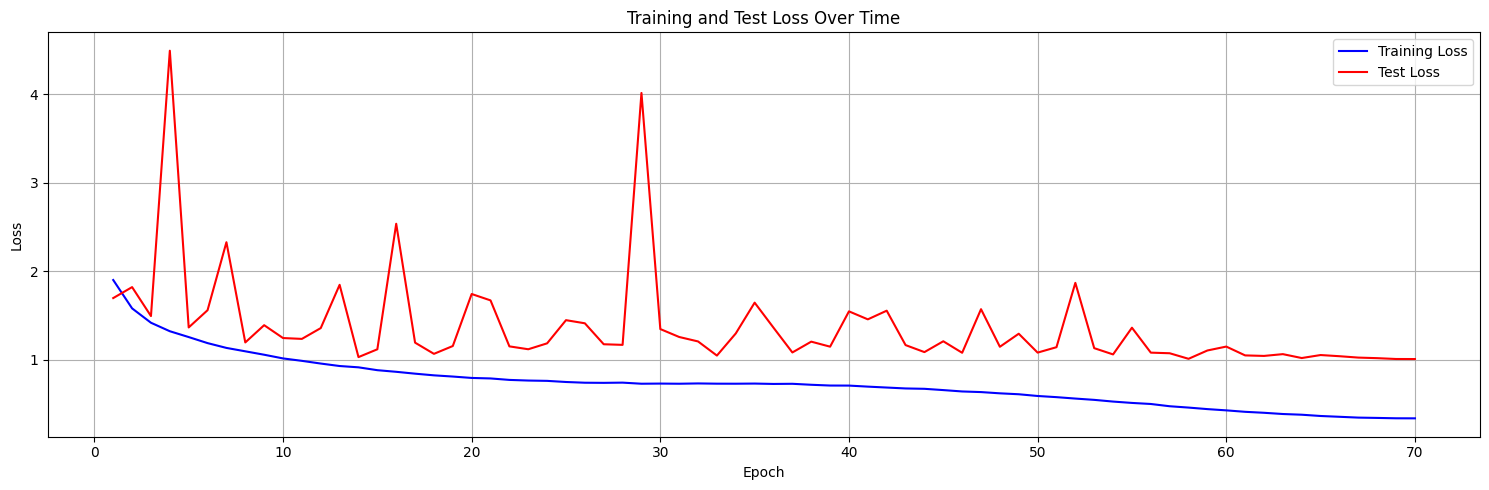


Plotting Learning Rate...


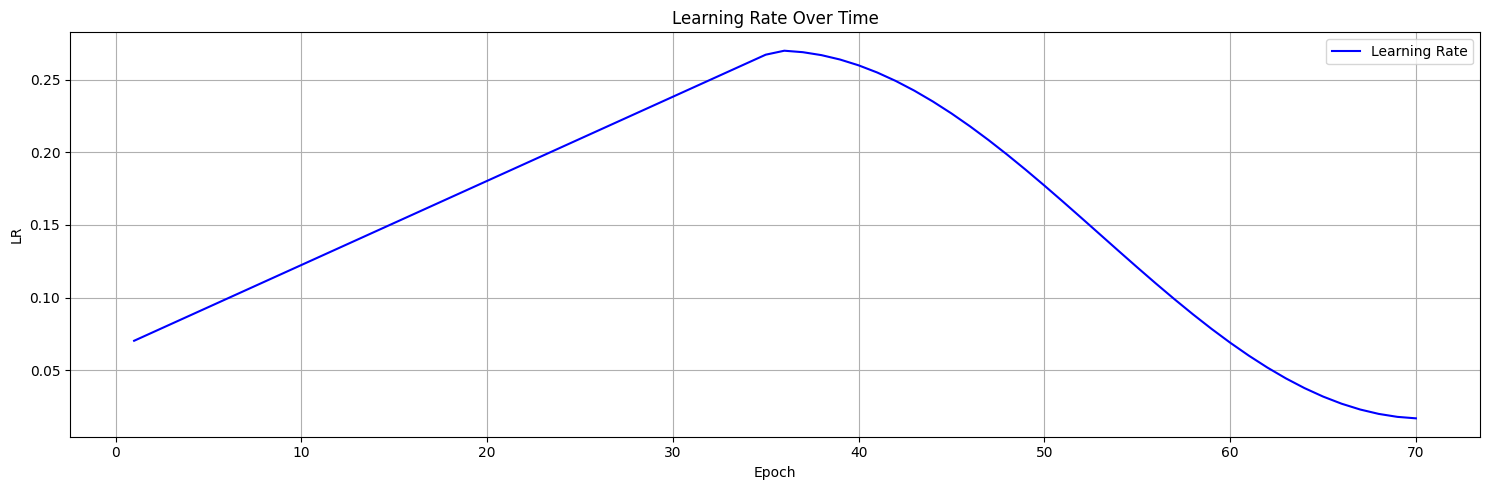


Plotting confusion matrix...


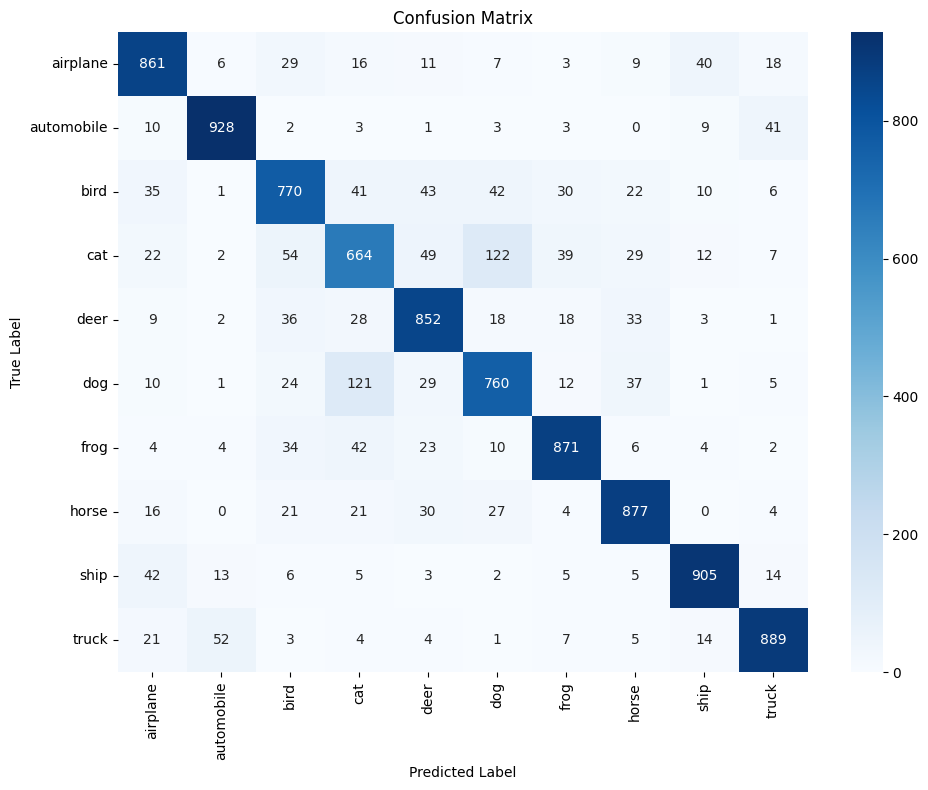


Plotting per-class metrics...


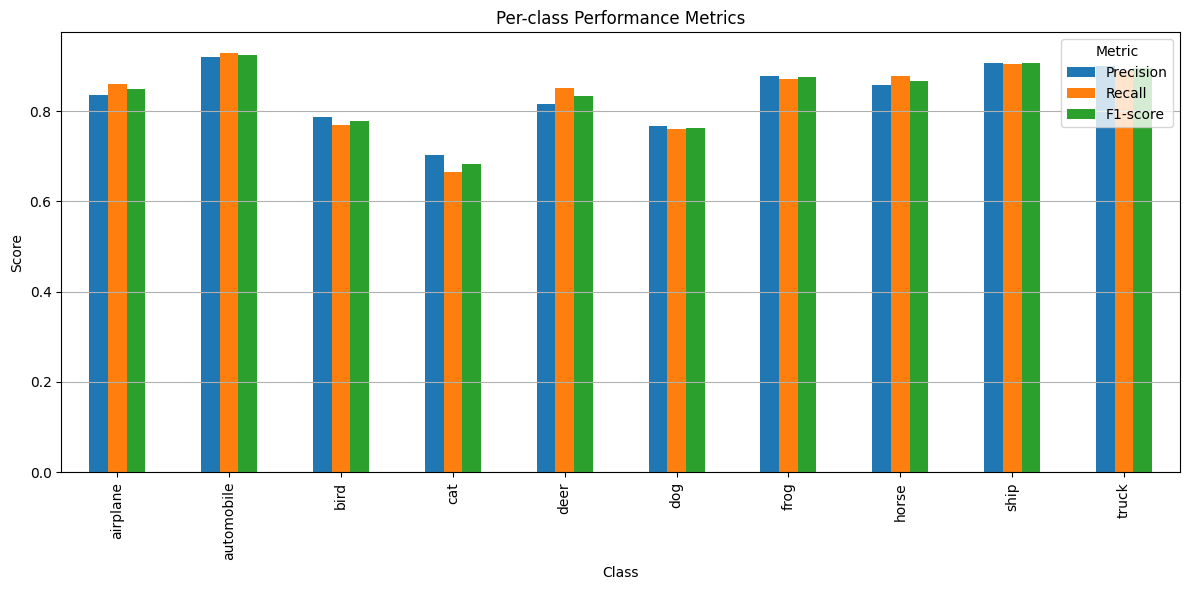


Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.79      0.77      0.78      1000
         cat       0.70      0.66      0.68      1000
        deer       0.82      0.85      0.83      1000
         dog       0.77      0.76      0.76      1000
        frog       0.88      0.87      0.87      1000
       horse       0.86      0.88      0.87      1000
        ship       0.91      0.91      0.91      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [48]:

analyze_model_performance(
    loss_history=loss_history,
    test_loss_history=test_loss_history,
    lr_history=lr_history,
    X_test=X_test,
    y_test=y_test,
    class_names=cifar10_classes
)